# Gradient Boosting (XGBoost)

**Rossmann Store Sales**
Forecast sales using store, promotion, and competitor data

This is a Kaggle competition and can be found [here](https://www.kaggle.com/competitions/rossmann-store-sales/overview)

In this notebook I use `Gradient Boosting` implemented in `XGBoost` to predict `Sales`.

The best validation Root Mean Square Percentage Error (RMSPE) is around `0.22` (RMSE is around `1040`).
The results of the random searches is on [wandb](https://wandb.ai/daniele-didino/rossmann_store_sales)

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate
import xgboost as xgb
import wandb

# my functions
from utils import RMSPE, RMSPE_score_func
from pipeline import full_pipeline

# Load data

In [2]:
# Load the dataset
def load_ds(path: Path, filename: str) -> pd.DataFrame:
    """Read the dataset csv file as a pandas dataframe."""
    return pd.read_csv(path / filename)

# Load dataset
dataset_path = Path().absolute() / "data"
filename = "X_y_train.csv"
X_y_train = load_ds(dataset_path, filename)

X_train = X_y_train # include "Sales", CombinedAttributesAdder() drops it
y_train = X_y_train.loc[:, "Sales"].copy()

print(f"Shape X_y_train: {X_y_train.shape}")
print(f"Shape X_train:   {X_train.shape}")
print(f"Shape y_train:   {y_train.shape}")

Shape X_y_train: (675470, 18)
Shape X_train:   (675470, 18)
Shape y_train:   (675470,)


# Gradient Boosting

In [3]:
xgb_regressor = xgb.XGBRegressor(
    objective="reg:squarederror",  # For regression
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=123
)

In [4]:
gb_reg = Pipeline([
    ("preparation", full_pipeline),
    ("xgb", xgb_regressor)])

In [5]:
gb_reg.fit(X_train, y_train)

Pipeline(steps=[('preparation',
                 Pipeline(steps=[('attribs_adder', CombinedAttributesAdder()),
                                 ('cols_transformer',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('std_scaler',
                                                                                    StandardScaler())]),
                                                                   ['SchoolHoliday',
                                                                    'Promo2',
                                                                    'Month_mean',
                                                                    'Store_mean',
                                                                    'DayOfWeek_mean',
                                                                    'PromoStore_mean',
                                                                    'CD_clip_bins_clip']),
                                                                  ('cat',
                                                                   Pipeli...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=6, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=123, ...))])

In [6]:
y_pred = gb_reg.predict(X_train)
rmse = mean_squared_error(y_train, y_pred, squared=False)
print(f"RMSE: {rmse:.2f}")

RMSE: 1117.19


In [7]:
RMSPE(y_train, y_pred)

0.24491358230252744

The Root Mean Square Percentage Error on the train set is:

`RMSPE = 0.25`

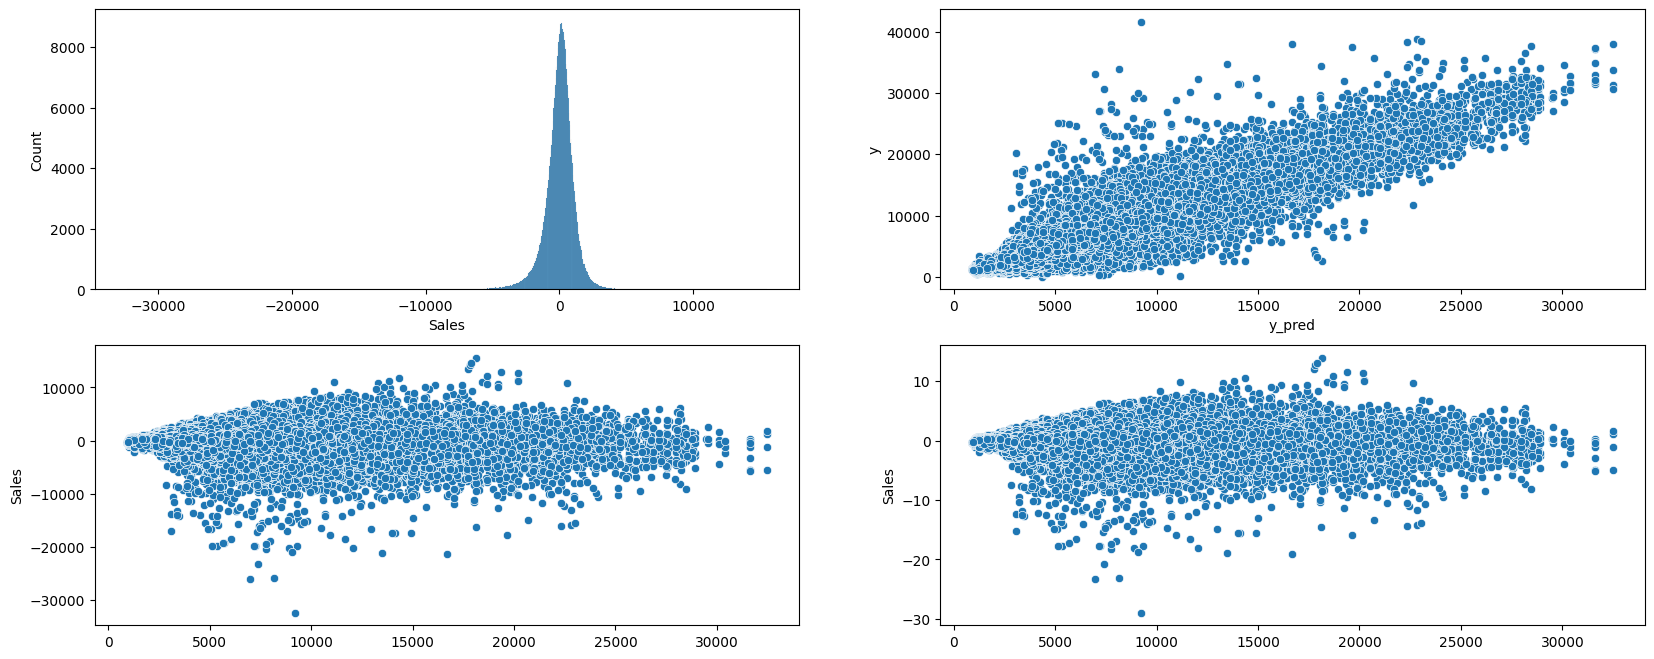

In [8]:
res = (y_pred - y_train)
res_normed = (res - np.mean(res))/np.std(res)


plt.figure(figsize=(20, 8))

plt.subplot(2, 2, 1)
sns.histplot(x=res)

plt.subplot(2, 2, 2)
sns.scatterplot(x=y_pred, y=y_train)
plt.xlabel("y_pred")
plt.ylabel("y")

plt.subplot(2, 2, 3)
sns.scatterplot(x=y_pred, y=res)

plt.subplot(2, 2, 4)
sns.scatterplot(x=y_pred, y=res_normed)

plt.show()

# Weights & Biases (random search)

In [9]:
parameters_dict = {
    # "n_estimators": {"values": [100]},
    # "max_depth":  {"values": [7]},
    # "learning_rate":  {"values": [0.5]},
    "subsample":  {"values": [1.0]},
    "colsample_bytree":  {"values": [1.0]},
}

parameters_dict.update({
    'n_estimators': {
        # a flat distribution of integers between min and max
        'distribution': 'int_uniform',
        'min': 500,
        'max': 1000
      },
      "max_depth": {
        # a flat distribution of integers between min and max
        'distribution': 'int_uniform',
        'min': 3,
        'max': 7
      },
      'learning_rate': {
        # a flat distribution between min and max
        'distribution': 'uniform',
        'min': 0.001,
        'max': 0.1
      },
    })

metric = {
    'name': 'loss',
    'goal': 'minimize'   
}

sweep_config = {
    'method': 'random'
}

sweep_config['parameters'] = parameters_dict
sweep_config['metric'] = metric

sweep_config

{'method': 'random',
 'parameters': {'subsample': {'values': [1.0]},
  'colsample_bytree': {'values': [1.0]},
  'n_estimators': {'distribution': 'int_uniform', 'min': 500, 'max': 1000},
  'max_depth': {'distribution': 'int_uniform', 'min': 3, 'max': 7},
  'learning_rate': {'distribution': 'uniform', 'min': 0.001, 'max': 0.1}},
 'metric': {'name': 'loss', 'goal': 'minimize'}}

In [10]:
sweep_id = wandb.sweep(sweep=sweep_config, project="rossmann_store_sales")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: u4clvr2f
Sweep URL: https://wandb.ai/daniele-didino/rossmann_store_sales/sweeps/u4clvr2f


In [11]:
def build_model(config):
    xgb_regressor = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators= config.n_estimators,
        max_depth=config.max_depth,
        learning_rate=config.learning_rate,
        subsample=config.subsample,
        colsample_bytree=config.colsample_bytree,
        seed=536)
    
    pipelile_reg = Pipeline([
        ("preparation", full_pipeline),
        ("xbg", xgb_regressor)])
    
    return pipelile_reg


def build_dataset(X_train, y_train):
    return X_train, y_train


def train(config=None):
    # Initialize a new wandb run
    with wandb.init(config=config):
        # If called by wandb.agent, this config will be set by Sweep Controller
        config = wandb.config

        model = build_model(config)
        X, y = build_dataset(X_train, y_train)

        scorer = {
            'main': 'neg_mean_squared_error',
            'custom': make_scorer(RMSPE_score_func, greater_is_better=False)
        }

        scores = cross_validate(
            model,
            X,
            y,
            cv=5,
            scoring=scorer,
            return_train_score=True)
        
        rmse_val = np.sqrt(-1 * scores["test_main"].mean())
        rmse_train = np.sqrt(-1 * scores["train_main"].mean())
        rmspe_val = -1 * scores["test_custom"].mean()
        rmspe_train = -1 * scores["train_custom"].mean()
        
        wandb.log({
            "loss": rmse_val,
            "RMSE_val": rmse_val,
            "RMSPE_val": rmspe_val,
            "RMSE_train": rmse_train,
            "RMSPE_train": rmspe_train,
        })

In [ ]:
wandb.agent(sweep_id, train, count=20)

In [60]:
# wandb.finish()